In [74]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import json
import pathlib

In [18]:
rts = []
answers = []
for result in pathlib.Path("exp_results/").glob("*"):
    with open(result.relative_to(""), "r") as file:
        result = json.load(file)
        rts_this = []
        answers_this = [[], []]
        for trial in result:
            if "words" in trial.keys():
                rts_this.append(float(trial["rt"]))
            if trial["trial_type"] == "survey" and int(trial["trial_index"]) > 2:
                answers_this[0].append(trial["response"]["quality"])
                answers_this[1].append(trial["response"]["difficulty"])
        rts.append(rts_this)
        answers.append(answers_this)
        

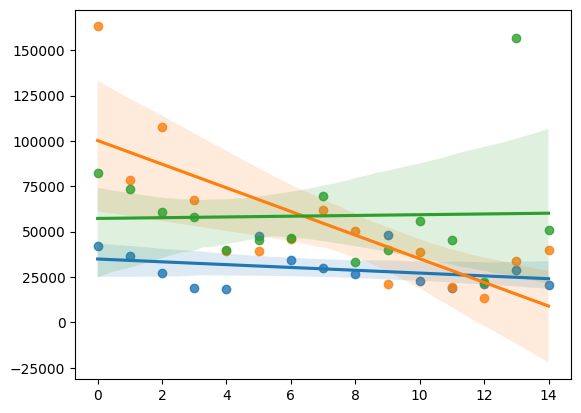

In [21]:
x = list(range(15))
for rt in rts:
    sns.regplot(x=x, y=rt)

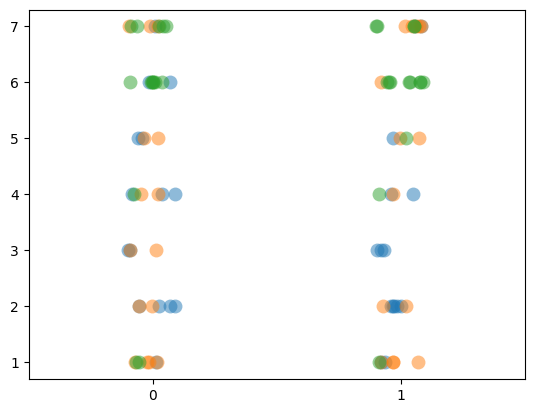

In [53]:
for answer in answers:
    x = [0] * 15 + [1] * 15
    y = answer[0] + answer[1]
    sns.stripplot(x=x, y=y, s=10, alpha=.5)

## Check if everyone passes all attention checks

In [1]:
from pathlib import Path
import json

In [2]:
result_files = Path("exp_results/raw").glob("*/**/data.txt")
results = []
for result_file in result_files:
    with open(result_file, 'r') as file:
        results.append(json.load(file))

In [11]:
attention_checks = lambda run: len([trial for trial in run if "correct" in trial.keys() and trial["correct"] == True])
freetext         = lambda run: [trial["response"]["freetext"] for trial in run if "response" in trial.keys() and type(trial["response"]) not in (str, int) and "freetext" in trial["response"].keys() and trial["response"]["freetext"] != None]
item_list        = lambda run: run[0]["list"]
clues_given      = lambda run: [(trial["clue"], trial["count"]) for trial in run if "selection" in trial.keys()]

## Coding all the data

In [32]:
import pandas as pd

In [33]:
ids = [result[2]["response"]["prolific"] for result in results]
def map_clue(clue):
    remapper = {"clothes": "clothe", "stuck": "stick", "rings": "ring", "shapes": "shape", "insects": "insect", "2": "twos", "duracell": "battery", "buliding": "building", "stores": "store", "paforated": "perforate"}
    if clue in remapper.keys():
        return remapper[clue]
    else:
        return clue

In [34]:
trials = []
for run in results:
    participant_id = ids.index(run[2]["response"]["prolific"])
    the_list = run[0]["list"]
    for i in [5, 7, 9, 11, 13] + [17, 19, 21, 23, 25, 28, 30, 32, 34, 36]:
        item = run[i]["item"]
        words = run[i]["words"]
        clue = run[i]["clue"]
        count = run[i]["count"]
        assoc = run[i]["assoc"]
        rt = run[i]["rt"]
        quality = run[i+1]["response"]["quality"]
        difficulty = run[i+1]["response"]["difficulty"]
        freetext = run[i+1]["response"]["freetext"]
        board_dist = []
        if i < 14:
            block = 1
            agent = "-"
            guesses = []
        else:
            block = 2
            agent = run[i]["agent"]
            guesses = run[i]["guesses"]
        trials.append({
            "participant_id": participant_id,
            "list": the_list,
            "block": block,
            "item": item,
            "agent": agent,
            "words": words,
            "clue": map_clue(clue.lower().strip()),
            "count": count,
            "assoc": assoc,
            "guesses": guesses,
            "board_dist": board_dist,
            "rt": rt,
            "quality": quality,
            "difficulty": difficulty,
            "freetext": freetext            
        })

In [36]:
df = pd.DataFrame.from_dict(trials)
df.to_csv("exp_results/raw.csv", sep=";", index=False)

## Block 1

In [16]:
import pickle
import numpy as np
import pandas as pd
from ast import literal_eval

In [35]:
def eval_df(frame, columns):
    for column in columns:
        frame[column] = frame[column].map(literal_eval)
    return frame

,participant_id,list,block,item,agent,words,clue,count,assoc,guesses,board_dist,rt,quality,difficulty,freetext


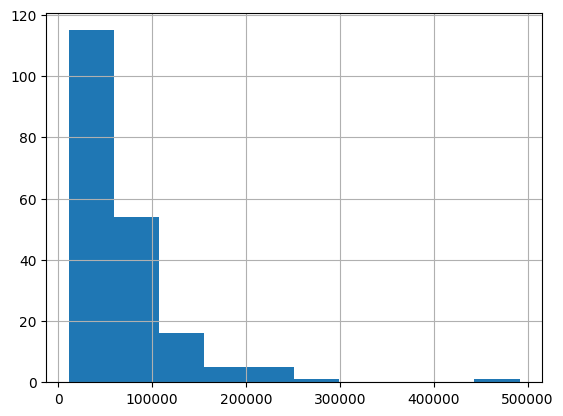

In [17]:
df = pd.read_csv("exp_results/raw.csv", sep=";")

# Drop illegal clues
df = df[df["clue"] != "battery"]
df = df[df["clue"] != "twos"]
df = df[df["clue"] != "oo"]

df = eval_df(df, ["words", "assoc", "guesses"])

block1 = df[df["block"] == 1]
block1["rt"].hist()
# Check for outliers to remove
block1[block1["rt"] < (block1["rt"].mean() - 2 * block1["rt"].std())]

In [18]:
tester = []
for s in [0, 50, 100, 150, 200, 250, 300, 330]:
    with open(f"openai_2-{s}.pkl", "rb") as file:
        if s != 300:
            tester += pickle.load(file)
        else:
            tester += pickle.load(file)[:30]

In [313]:
with open("swow-330.pkl", "rb") as file:
    f = pickle.load(file)
len(f)

25

In [20]:
pd.DataFrame(tester).to_csv("exp_results/guesses_openai.csv", sep=";", index=False)

In [27]:
from scipy.stats import entropy, shapiro, mannwhitneyu

In [144]:
def game_score(trial):
    score = 0
    for guess in trial["guesses"]:
        if trial["assoc"][trial["words"].index(guess)] == 0:
            score += 1
        else:
            return score - 1
    return score

def score_ratio(trial):
    score = 0
    for guess in trial["guesses"]:
        if trial["assoc"][trial["words"].index(guess)] == 0:
            score += 1
    return score / len(trial["guesses"])

def random_score(trial):
    good = 6
    score = 0
    for _ in range(trial["count"]):
        if random.random() < (good / 16):
            score += 1
            good -= 1
        else:
            return score - 1
    return score

def belief_distance(trial):
    dist_1 = trial["board_dist"]
    dist_2 = 1-np.array(trial["assoc"])
    return entropy(dist_2, dist_1) # + entropy(dist_2, dist_1)

def parse_dist(trial):
    return np.array([float(x) for x in trial["board_dist"].replace("\n", "")[1:-1].split()])

def get_clue(trial):
    return trial["clue"]

In [195]:
block1_results = eval_df(pd.read_csv("exp_results/guesses_swow.csv", sep=";", index_col=None), ["words", "assoc", "guesses"])
block1_results["board_dist"] = block1_results.apply(parse_dist, axis=1)
block1_results["score"] = block1_results.apply(game_score, axis=1)
block1_results["score_ratio"] = block1_results.apply(score_ratio, axis=1)
block1_results["belief_distance"] = block1_results.apply(belief_distance, axis=1)

c:\Users\flohk\Anaconda3\envs\CodenamesRSA\Lib\site-packages\scipy\stats\_entropy.py:139: RuntimeWarning: invalid value encountered in divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


In [233]:
block1_RSA_scores = block1_results[block1_results["agent"].str.contains("RSA")]["score"].tolist()
block1_other_scores = block1_results[block1_results["agent"].str.contains("other")]["score"].tolist()
block1_random_scores = block1_results.apply(random_score, axis=1).tolist()

block1_RSA_belief_distance = block1_results[block1_results["agent"].str.contains("RSA")]["belief_distance"].to_numpy()
block1_other_belief_distance = block1_results[block1_results["agent"].str.contains("other")]["belief_distance"].to_numpy()
indices = [i for i, e in enumerate(block1_RSA_belief_distance) if not np.isnan(e)]
block1_RSA_belief_distance = block1_RSA_belief_distance[indices]
block1_other_belief_distance = block1_other_belief_distance[indices]

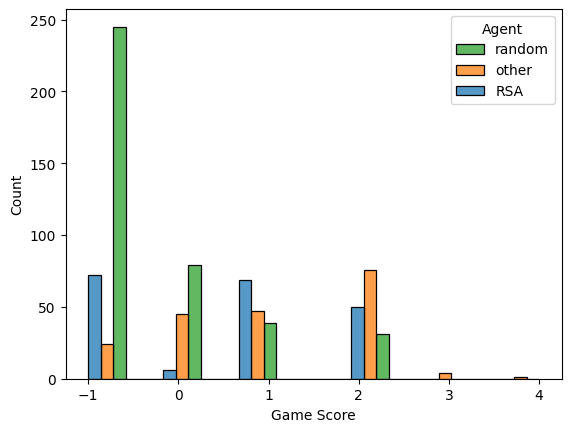

In [197]:
g = sns.histplot([block1_RSA_scores, block1_other_scores, block1_random_scores], multiple="dodge")
plt.legend(title='Agent', loc='upper right', labels=['random', 'other', 'RSA'])
plt.xticks([-1, 0, 1, 2, 3, 4])
plt.gca().set_xlabel("Game Score")
plt.show()

In [198]:
print(shapiro(block1_RSA_scores))
print(shapiro(block1_other_scores))
print(mannwhitneyu(block1_RSA_scores, block1_other_scores, alternative="greater"))

ShapiroResult(statistic=0.7857100367546082, pvalue=1.0475673622420455e-15)
ShapiroResult(statistic=0.8741414546966553, pvalue=9.594162270198936e-12)
MannwhitneyuResult(statistic=15225.5, pvalue=0.9999396125881578)


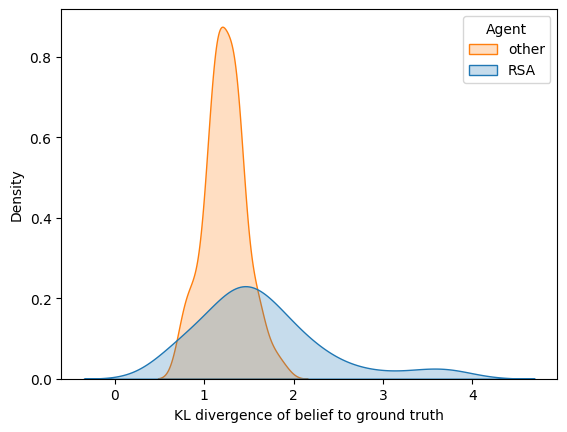

In [236]:
g = sns.kdeplot([block1_RSA_belief_distance, block1_other_belief_distance], multiple="layer", fill=True, common_norm=True)
plt.legend(title='Agent', loc='upper right', labels=['other', 'RSA'])
# plt.xticks([-1, 0, 1, 2, 3, 4])
plt.gca().set_xlabel("KL divergence of belief to ground truth")
plt.show()

In [299]:
block1_results["belief_distance"].replace(np.inf, 0).replace(np.nan, 0).argsort()[-10:]

384     48
385    302
386    231
387    384
388     82
389    204
390     74
391    304
392    114
393    324
Name: belief_distance, dtype: int64

In [300]:
block1_results["belief_distance"][114]

3.7517811295455377

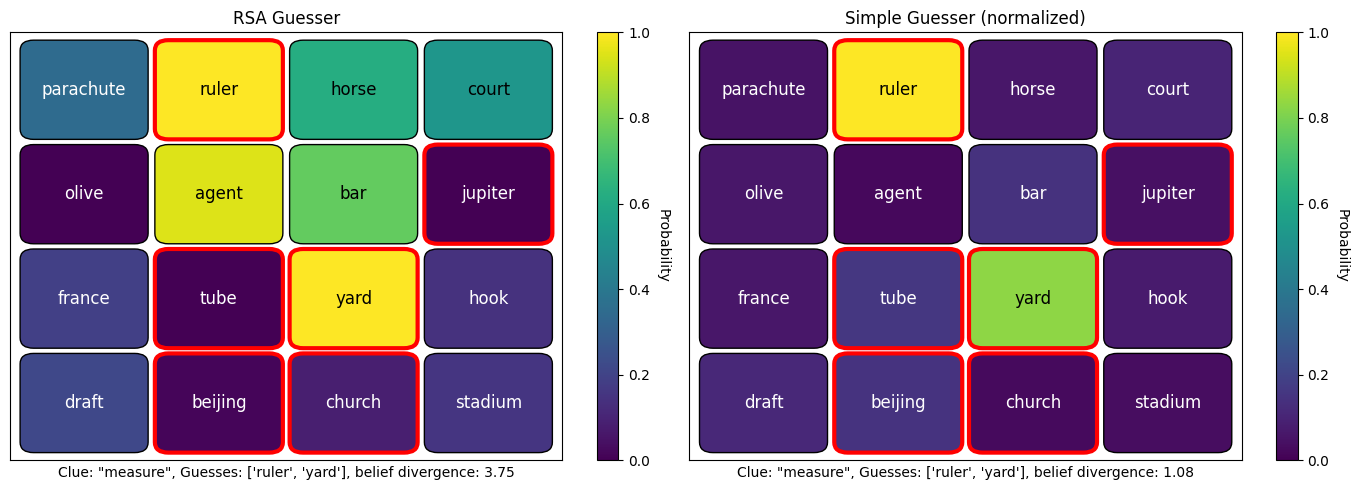

In [310]:
bad_example_1 = block1_results.iloc[114]
bad_example_2 = block1_results.iloc[115]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
create_labeled_heatmap(bad_example_1["words"], bad_example_1["board_dist"].reshape(4,4), 1-np.array(bad_example_1["assoc"]), f'Clue: "{bad_example_1["clue"]}", Guesses: {bad_example_1["guesses"]}, belief divergence: {bad_example_1["belief_distance"]:1.2f}', "RSA Guesser", ax=ax1)
create_labeled_heatmap(bad_example_2["words"], bad_example_2["board_dist"].reshape(4,4) / bad_example_2["board_dist"].max(), 1-np.array(bad_example_2["assoc"]), f'Clue: "{bad_example_2["clue"]}", Guesses: {bad_example_2["guesses"]}, belief divergence: {bad_example_2["belief_distance"]:1.2f}', "Simple Guesser (normalized)", ax=ax2)
plt.show()

## Block 2

In [3]:
import random

In [31]:
def game_score(trial):
    score = 0
    for guess in trial["guesses"]:
        if trial["assoc"][trial["words"].index(guess)] == 1:
            score += 1
        else:
            return score - 1
    return score

def score_ratio(trial):
    score = 0
    for guess in trial["guesses"]:
        if trial["assoc"][trial["words"].index(guess)] == 1:
            score += 1
    return score / len(trial["guesses"])

def random_score(count):
    good = 10
    score = 0
    for _ in range(count):
        if random.random() < (good / 16):
            score += 1
            good -= 1
        else:
            return score - 1
    return score

In [5]:
# Block 2 boards: 17, 19, 21, 23, 25, 28, 30, 32, 34, 36
# Block 2 survey: 18, 20, 22, 24, 26, 29, 31, 33, 35, 37
block2_RSA   = []
block2_other = []
for run in results:
    for trial in [trial for trial in run if trial["trial_index"] in [17, 19, 21, 23, 25, 28, 30, 32, 34, 36]]:
        res = {
            "list": trial["list"],
            "item": trial["item"],
            "agent": trial["agent"],
            "index": trial["trial_index"],
            "words": trial["words"],
            "assoc": trial["assoc"],
            "clue": trial["clue"],
            "count": trial["count"],
            "guesses": trial["guesses"],
        }
        res["score"] = game_score(res)
        res["score_ratio"] = score_ratio(res)
        if "RSA" in trial["agent"]:
            block2_RSA.append(res)
        else:
            block2_other.append(res)

In [6]:
block2_RSA_scores   = [trial["score"] for trial in block2_RSA]
block2_other_scores = [trial["score"] for trial in block2_other]
random_scores = random_baseline(block2_other)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

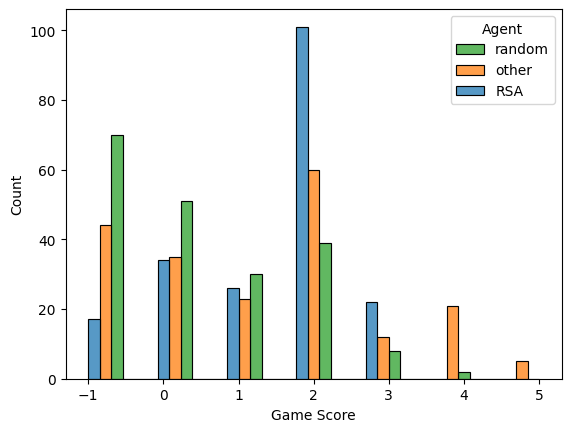

In [8]:
g = sns.histplot([block2_RSA_scores, block2_other_scores, random_scores], multiple="dodge")
plt.legend(title='Agent', loc='upper right', labels=['random', 'other', 'RSA'])
plt.xticks([-1, 0, 1, 2, 3, 4, 5])
plt.gca().set_xlabel("Game Score")
plt.show()

In [13]:
from scipy.stats import mannwhitneyu, shapiro

In [15]:
print(shapiro(block2_RSA_scores))
print(shapiro(block2_other_scores))
print(mannwhitneyu(block2_RSA_scores, block2_other_scores, alternative="greater"))

ShapiroResult(statistic=0.8385377526283264, pvalue=1.2339634251467418e-13)
ShapiroResult(statistic=0.9088748693466187, pvalue=9.598184469439275e-10)
MannwhitneyuResult(statistic=21846.0, pvalue=0.04835296680848867)


### Heatmapping

In [166]:
def vectorize_answers(words, guesses):
    result = []
    for word in words:
        if word in guesses:
            result.append(1)
        else:
            result.append(0)
    return result

def answers_per_item(items):
    result = [None] * (max(item["item"] for item in items) + 1)
    for item in items:
        item_n = item["item"]
        if result[item_n] == None:
            result[item_n] = {"clue": item["clue"], "count": item["count"], "words": item["words"], "answers": np.zeros(16), "assoc": item["assoc"], "scores": []}
        result[item_n]["answers"] += np.array(vectorize_answers(item["words"], item["guesses"]))
        result[item_n]["scores"].append(item["score"])
    return [res for res in result if res is not None]

In [252]:
from matplotlib.patches import FancyBboxPatch

def create_labeled_heatmap(words, probabilities, thick_outline_mask, x_label="", title="", ax=None):
    a = False if ax else True
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 5))
    
    # Reshape flattened inputs into 2D arrays
    words_2d = np.array(words).reshape(4, 4)
    thick_outline_mask_2d = np.array(thick_outline_mask).reshape(4, 4)
    
    # Define spacing and corner radius
    spacing = 0.05
    corner_radius = 0.1
    
    # Create the base for the heatmap
    ax.set_xlim(0-spacing, 4+spacing)
    ax.set_ylim(4+spacing, 0-spacing)
    
    # Loop over data dimensions and create text annotations + boxes
    for i in range(4):
        for j in range(4):
            # Determine if this cell should have a thick outline
            is_thick = thick_outline_mask_2d[i][j]
            
            # Create box with rounded corners
            rect = FancyBboxPatch((j+spacing/2, i+spacing/2), 1-spacing, 1-spacing, 
                                  boxstyle=f"round,pad=0,rounding_size={corner_radius}",
                                  fill=True, facecolor=plt.cm.viridis(probabilities[i][j]),
                                  edgecolor='red' if is_thick else 'black',
                                  linewidth=3 if is_thick else 1)
            ax.add_patch(rect)
            
            # Add text
            ax.text(j+0.5, i+0.5, words_2d[i][j],
                    ha="center", va="center", fontsize=12,
                    color="white" if probabilities[i][j] < 0.5 else "black")
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.gcf().colorbar(sm, ax=ax)
    cbar.ax.set_ylabel("Probability", rotation=-90, va="bottom")
    
    # Add x-axis label and title
    ax.set_xlabel(x_label)
    ax.set_title(title)
    
    plt.tight_layout()
    if a:
        plt.show()


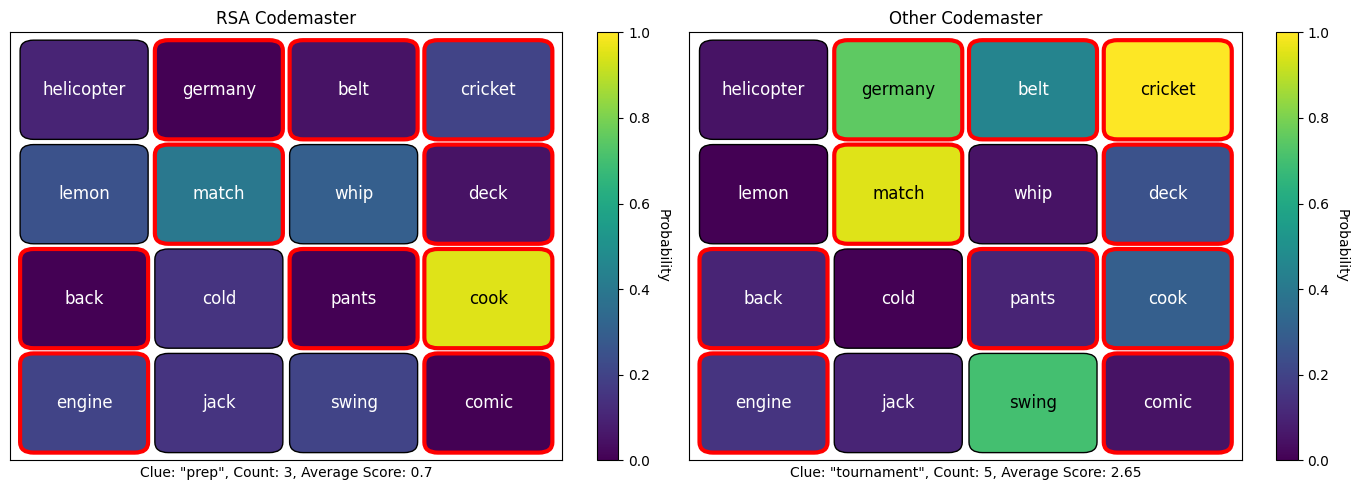

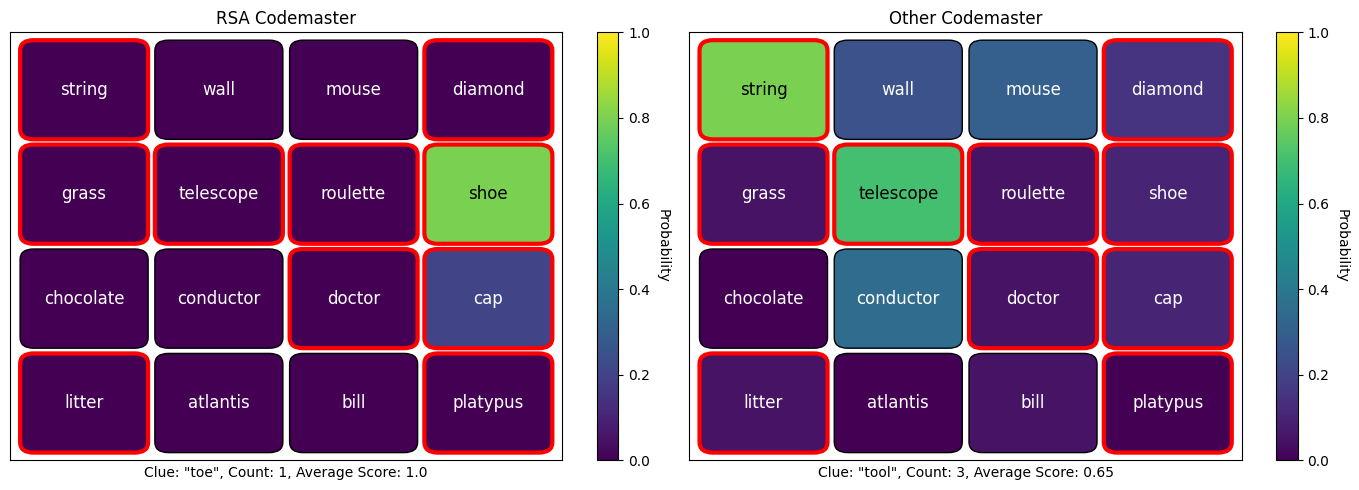

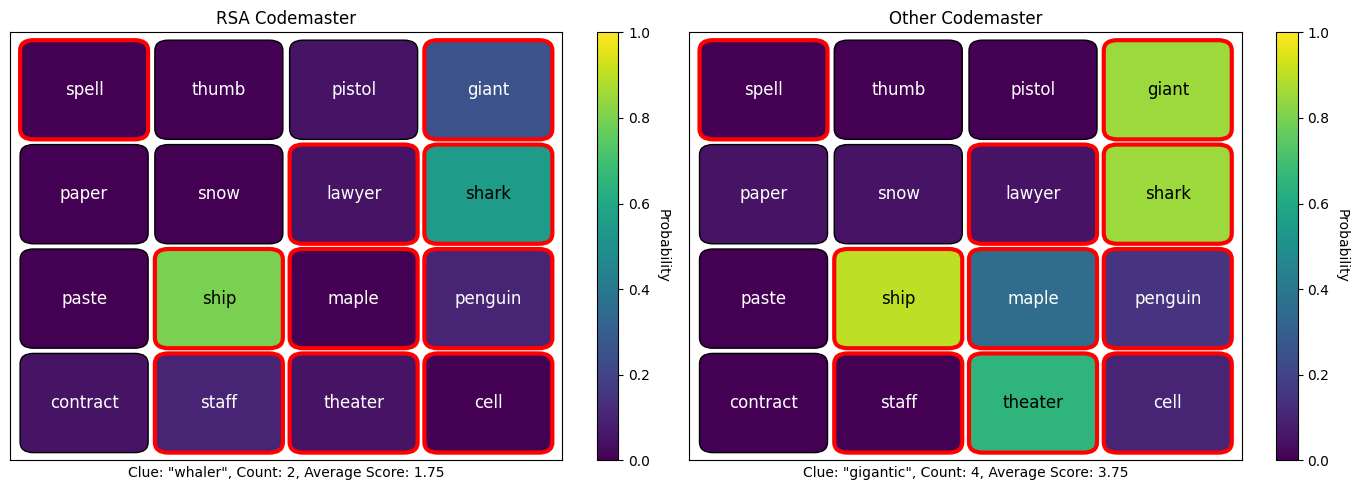

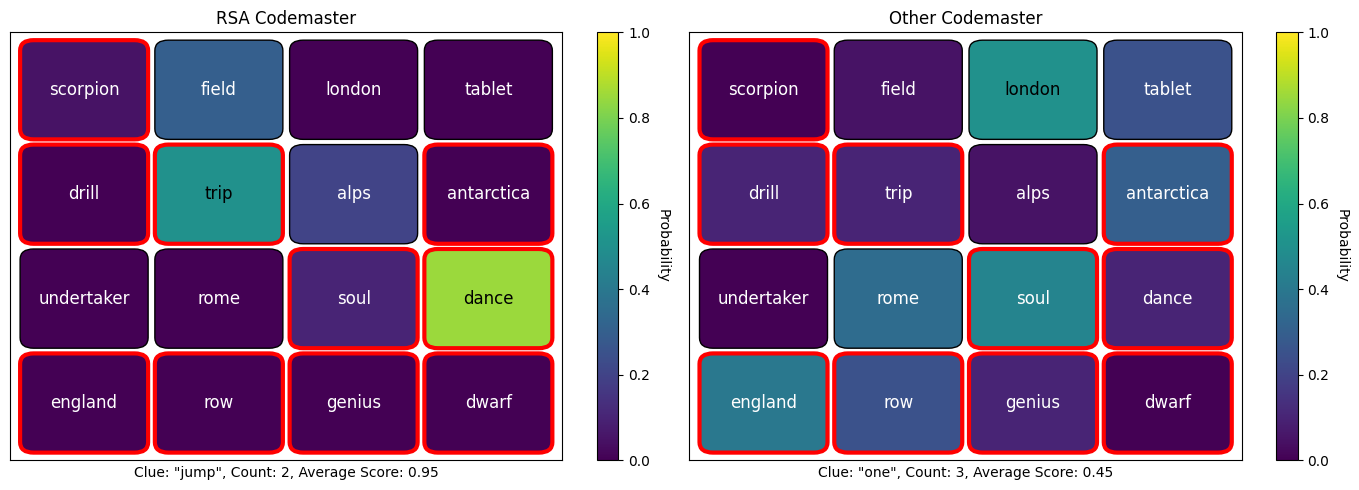

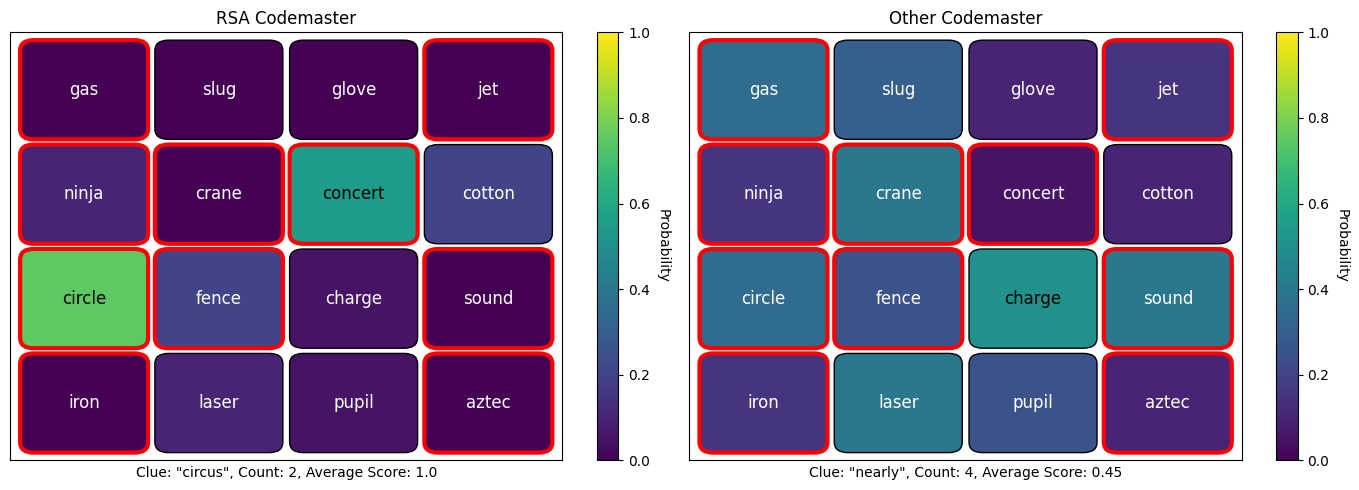

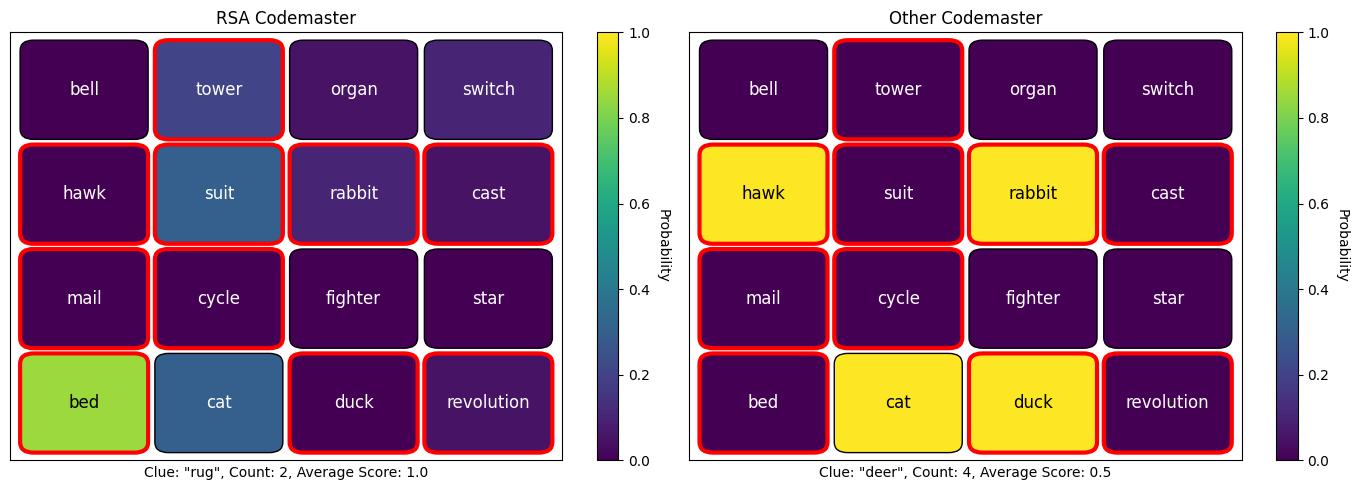

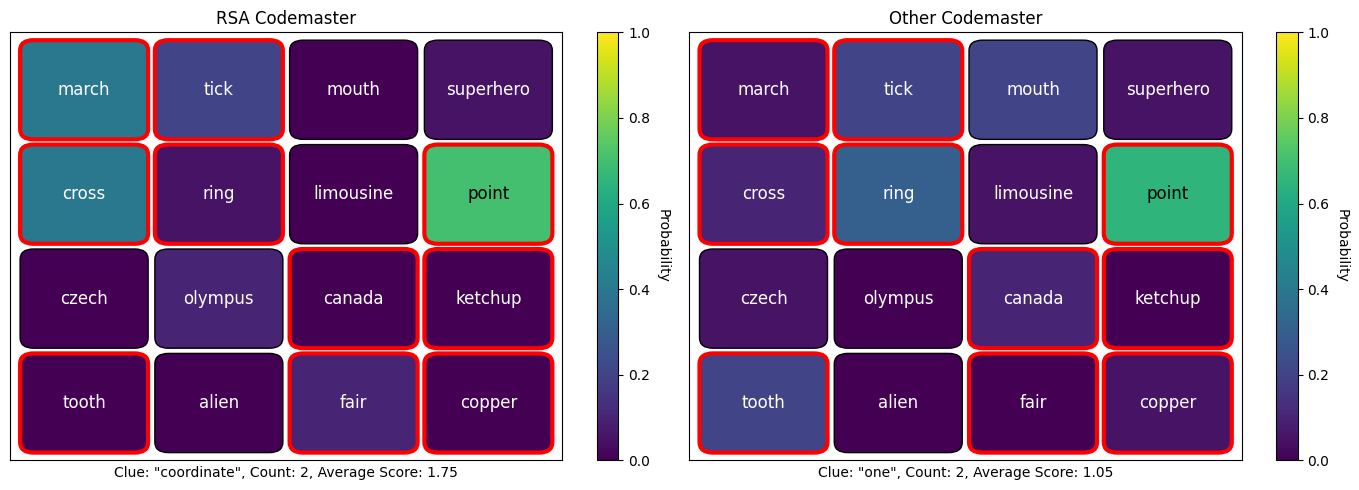

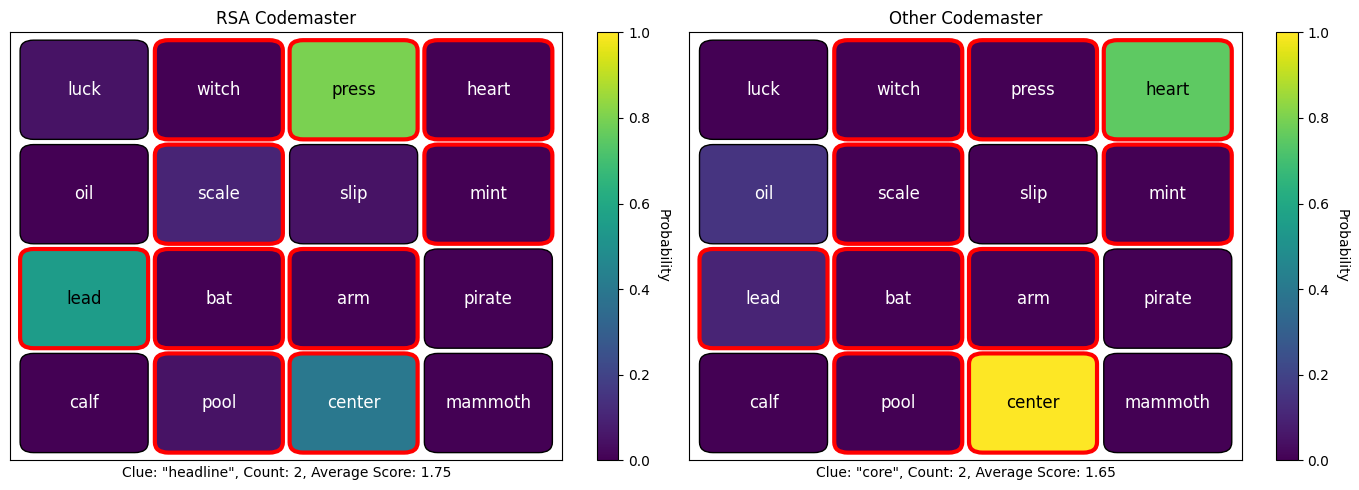

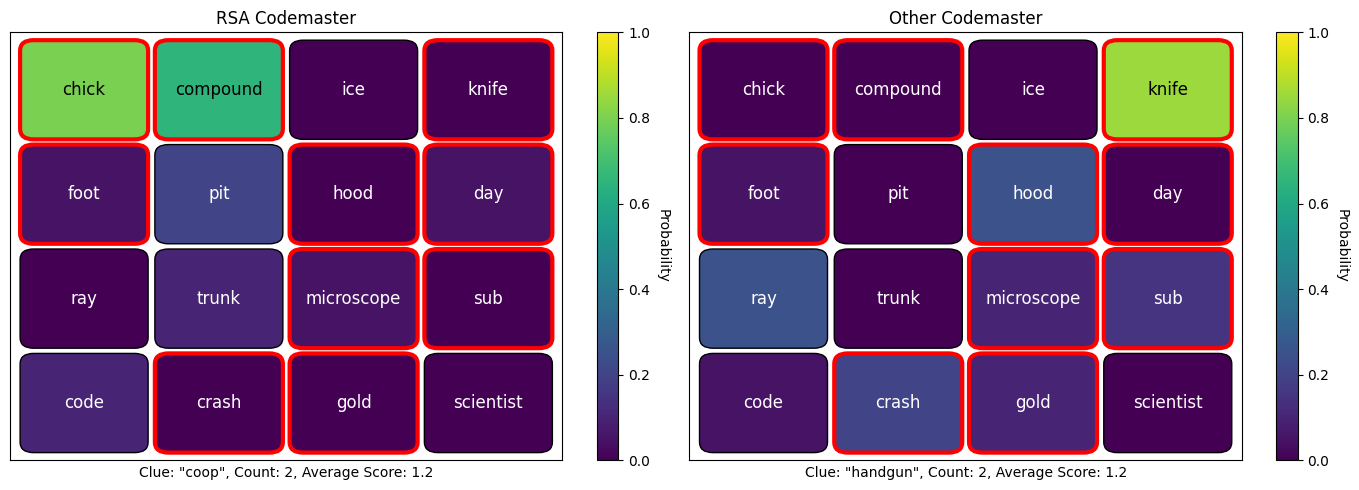

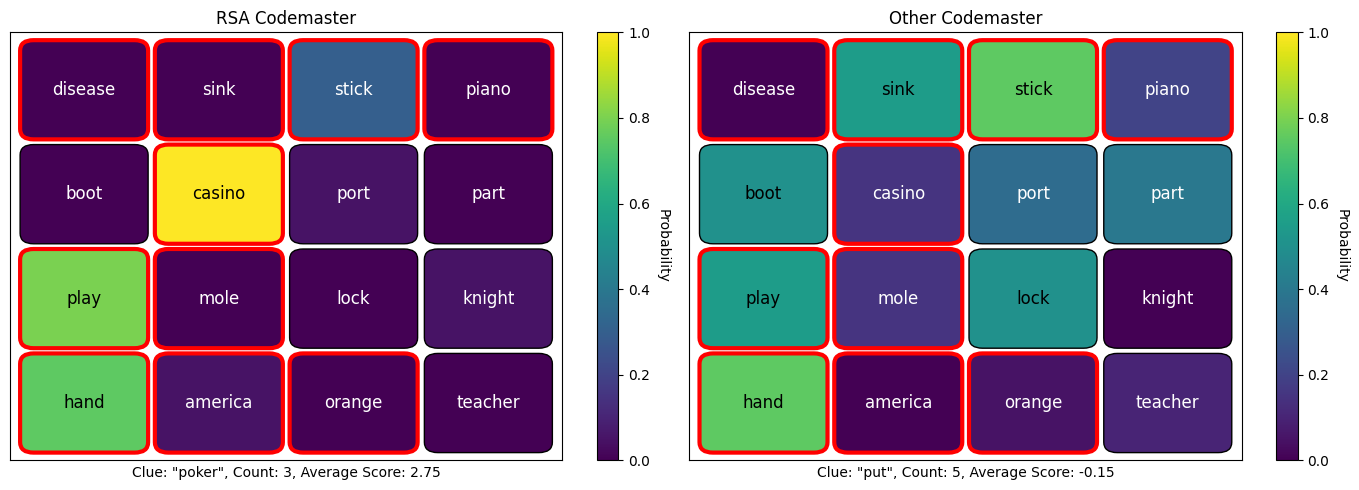

In [179]:
for (item1, item2) in zip(answers_per_item(block2_RSA), answers_per_item(block2_other)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    create_labeled_heatmap(item1["words"], item1["answers"].reshape(4,4) / 20, np.array(item1["assoc"]), f'Clue: "{item1["clue"]}", Count: {item1["count"]}, Average Score: {sum(item1["scores"]) / len(item1["scores"])}', "RSA Codemaster", ax=ax1)
    create_labeled_heatmap(item2["words"], item2["answers"].reshape(4,4) / 20, np.array(item2["assoc"]), f'Clue: "{item2["clue"]}", Count: {item2["count"]}, Average Score: {sum(item2["scores"]) / len(item2["scores"])}', "Other Codemaster", ax=ax2)
    plt.show()